Experiments for data classification with XGBoost trees and CNNs

In [2]:
# requirements
import os
import sys
sys.path.insert(0,'..') # to add parent directory
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from matplotlib import pyplot

## Exploration
Данные уже были посчитаны в прошлом блокноте, здесь они только подгружаются из файла.
Данные от 41 пациента, снятые в разных позах. Первая поза, это поза Хуторской. Вторая поза, это поза с выпрямленными руками. В этом блокноте данные позы хуторской отмечатся _h, а позы с прямыми руками, _v. 

In [3]:
data_v = np.genfromtxt('../CNN/data_cnn_vitr.csv', delimiter=',', dtype=None)
labels_v = data_v[:,0]
features_v = np.array(data_v[:,1:])
data_h = np.genfromtxt('../CNN/data_cnn.csv', delimiter=',', dtype=None)
labels_h = data_h[:,0]
features_h = data_h[:,1:]

In [4]:
# Проверка значений лейблов данных
labels_h == labels_v
labels = labels_h

In [5]:
print(features_v.shape, features_h.shape)

(41, 24) (41, 24)


На этом этапе мы решили только пробовать разделять пациентов с БП и контрольных пациентов. Удалим пациентов ЭТ из выборки.

In [6]:
features_h_pd_c = []
features_v_pd_c = []
labels_pd_c = [] 
for i in range(len(labels)):
    if labels[i]==0: # контроль
        features_h_pd_c.append(features_h[i,:])
        features_v_pd_c.append(features_v[i,:])
        labels_pd_c.append(0)
    if labels[i]==1: # БП
        features_h_pd_c.append(features_h[i,:])
        features_v_pd_c.append(features_v[i,:])
        labels_pd_c.append(1)
features_v_pd_c = np.array(features_v_pd_c)
features_h_pd_c = np.array(features_h_pd_c)

В итоге получили выборку из 28 пациентов

In [7]:
print(f'Всего пациентов {len(labels_pd_c)}, из них Паркинсон {sum(labels_pd_c)}')
print(features_v_pd_c.shape, features_h_pd_c.shape)

Всего пациентов 28, из них Паркинсон 20
(28, 24) (28, 24)


Text(0.5, 1.0, 'Heat Map Пациенты \n в позе Хуторской')

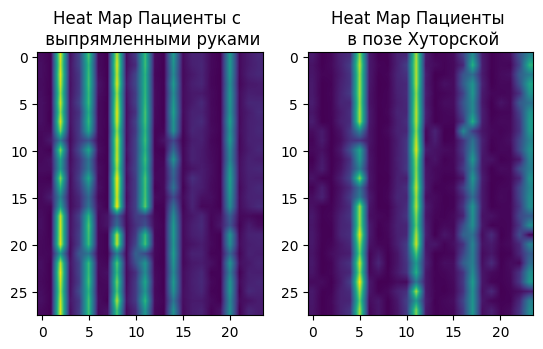

In [25]:
plt.figure()
 
# adding first subplot
plt.subplot(121)
plt.imshow(features_v_pd_c, cmap = 'viridis' , interpolation = 'bilinear')
plt.title( "Heat Map Пациенты с \n выпрямленными руками" )

plt.subplot(122)
plt.imshow(features_h_pd_c, cmap = 'viridis' , interpolation = 'bilinear')
plt.title( "Heat Map Пациенты \n в позе Хуторской" )

Я не уверена, что это хорошая идея, но добавим еще коэффициенты к этим сигналам. В дальнейшем я бы ими не пользовалась, потому что теоретически это то, что мы хотим выучить.

In [26]:
Ah_coefficients = [1.64,2.49,1.34,0.44,0.45,0.29,1.47,0.26,0.48,2.10,0.08,2.51, -1.14,0.90,1.79,0.83,-0.84,0.85,1.31,1.65,0.76,2.15,
0.58,2.09]
Bh_coefficients = [3.31,-1.99,1.76,1.15,-1.03,0.96,1.78,-1.87,0.59,-2.88,-0.31,-2.56, -3.34,-0.58,0.16,-0.40,1.66,-0.25,0.60,-0.12,-0.48,1.89,3.56,5.30]
Сh_coefficients = [0.38, -0.46,-1.31,1.30,0.86,-0.98,0.77,0.47, -0.29,-0.00,-0.44,-2.45, 0.47,0.06,-0.13,-1.24,0.01,3.27,0.47,0.21,-0.48,-0.03,1.00,3.06]
Dh_coefficients = [-0.07,1.13,-0.09,-0.27,0.95, 1.47,1.25,-0.08,1.14,1.13,-1.25,1.93, -1.43,1.49,0.54,1.16,-0.02,0.08,3.72,1.67,0.46,1.07,0.83,1.37]

In [27]:
Av_coefficients = [1.48,-2.09,0.16,1.02,-2.02,2.24,-0.05,0.04,1.28,-1.23,0.83,1.29, 2.91,-0.06,0.37,-0.89,0.60,-2.55,0.38,-0.69,1.039,1.21,0.49,0.39]
Bv_coefficients = [1.35,-2.00,-1.37,1.54,1.35,4.26,-0.25,0.99,0.34,-0.34,3.06,5.01, 3.20,-0.51,-2.86,0.39,-1.82,2.08,-2.10,1.76,-1.59,2.18,1.16,2.59]
Сv_coefficients = [1.45,1.34,-1.03,-0.37,0.97,1.80,-0.83,0.59,-0.43,1.00,1.72,-0.75, 2.81,-0.14,-1.87,-1.07,1.35,-0.18,-0.25,0.00,1.32,-1.33,1.16,2.22]
Dv_coefficients = [0.19,0.35,0.89,1.79,0.23,-0.36,0.15,0.84,1.11,0.15,-0.32,1.66, 0.44,1.34,0.46,-0.25,-0.24,0.08,-1.25,0.88,1.52,0.38,0.03,-0.95]


Сделаем преобразование как вы описываете в патенте на полученные сигналы. Построим гистограммы как в патенте. 
Здесь будем складывать две позы. возьмем только F1 & F2 соотвественно. 

Коэффициенты с 1 по 12 служат для того, чтобы при вычислении коэффициентов F1, F2, F3 и F4 учесть количество всплесков ЭМГ двух рук и двух ног пациента при записи в позе с выпрямленными на подлокотниках ладонями в трёх различных диапазонах частот. Эти 12 коэффициентов умножаются на соответствующие количества всплесков

F1 = sum (Qn * A)

In [32]:
f1_features_sum = []
f2_features_sum = []
for i, l in enumerate(labels_pd_c):
        weighted_sum_v = sum(features_v_pd_c [i]*Av_coefficients)
        weighted_sum_h = sum(features_h_pd_c [i]*Ah_coefficients)
        f1_features_sum.append(weighted_sum_v+weighted_sum_h)
        weighted_f2_sum_v = sum(features_v_pd_c[i]*Bv_coefficients)
        weighted_f2_sum_h = sum(features_h_pd_c [i]*Bh_coefficients)
        f2_features_sum.append(weighted_f2_sum_v+weighted_f2_sum_h)

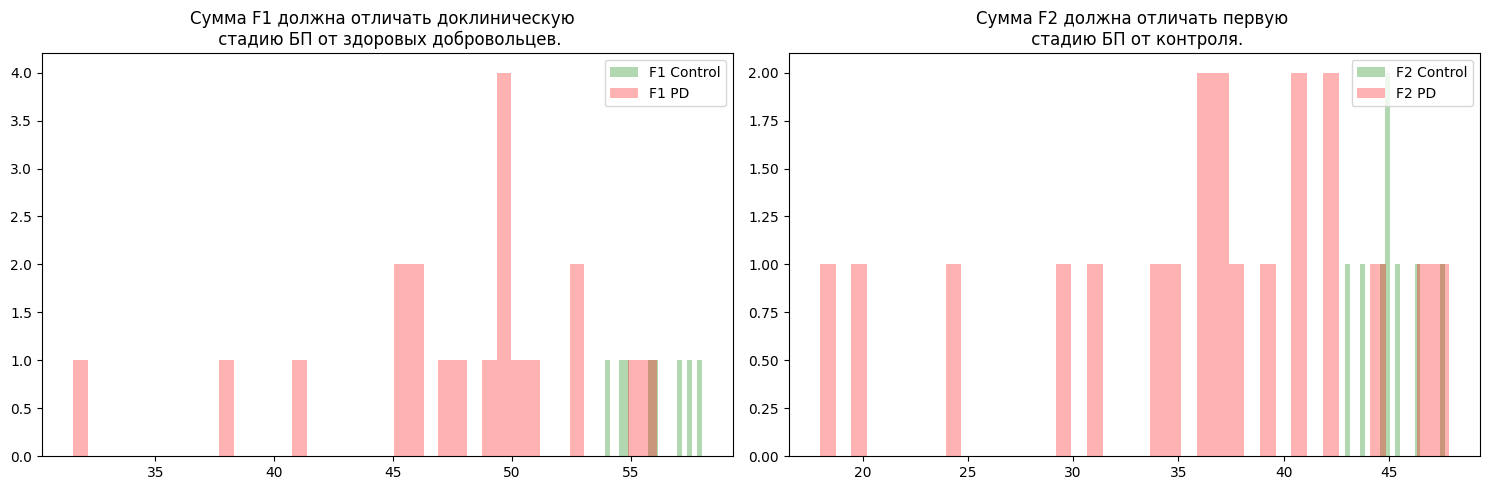

In [34]:
f,a = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(15)
a[0].hist(f1_features_sum[:8],20, alpha=0.3, label='F1 Control', color='g')
a[0].hist(f1_features_sum[8:], 40, alpha=0.3, label='F1 PD',color='r')
a[0].legend(loc='upper right')
a[0].set_title('Сумма F1 должна отличать доклиническую  \n стадию БП от здоровых добровольцев.')
a[1].hist(f2_features_sum[:8],20, alpha=0.3, label='F2 Control', color='g')
a[1].hist(f2_features_sum[8:], 40, alpha=0.3, label='F2 PD',color='r')
a[1].legend(loc='upper right')
a[1].set_title('Сумма F2 должна отличать первую \n стадию БП от контроля.')
plt.tight_layout()
plt.show()

По гистограммам мы видим, что идеального разделения нету. Особенно, в случае  F2.

## XGBoost trees
Теперь попробуем сделать все, что можно, с деревьями. Здесь я следую рекомендациям по маленьким датасетам [отсюда](https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook). 

Во всех случаях я использую кросс-валидацию, т.о, результаты проверены на множестве случайных выборок. 

Для деревьев, рекомендации:
    
* Restricting the maximum depth of trees via max_depth (low values)
* Making the model more conservative via gamma and eta (high values)
* L1 and L2 regularization via reg_alpha and reg_lambda (high values)

In [1]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from matplotlib import pyplot

In [ ]:
# Зададим необходимые параметры и функции для деревьев
# Тут по сто повторов разделения данных, чтобы получить точные результаты

# get a list of models to evaluate


def get_models(gamma=2,  eta=0.8,  reg_alpha=0.7, reg_lambda=0.7):
	models = dict()
	trees = [1,2, 5, 10, 50]
	for n in trees:
		models[str(n)] = XGBClassifier(n_estimators=n,  gamma=gamma,  eta=eta,  reg_alpha=reg_alpha, reg_lambda=reg_lambda)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y,random_state=1):
	cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=100, random_state=random_state)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores


Проверим деревья на наших данных. Здесь я не применяю коэффициенты, потому что деревья должны и без них справится.

In [8]:
X = features_v_pd_c +  features_h_pd_c
print(X.shape)

(28, 24)


>1 0.635 (0.097)
>2 0.650 (0.090)
>5 0.651 (0.088)
>10 0.651 (0.088)
>50 0.651 (0.088)


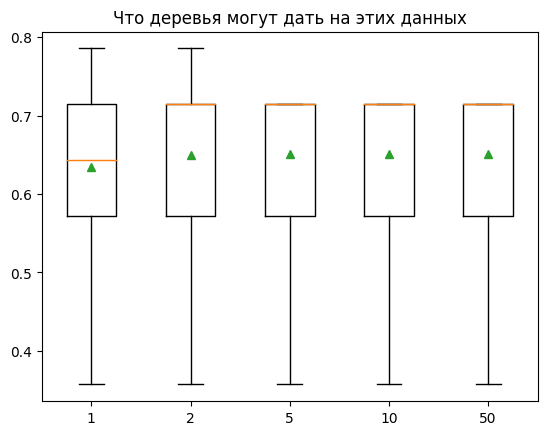

In [51]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, labels_pd_c,0)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.title('Что деревья могут дать на этих данных')
pyplot.show()

In [ ]:
Результаты довольно плохие.
Если я уберу регуляризацию, будут получше, но там больше шансов, что эксперименты на новых данных хуже повторятся.

>1 0.635 (0.097)
>2 0.668 (0.108)
>5 0.696 (0.111)
>10 0.706 (0.108)
>50 0.725 (0.104)


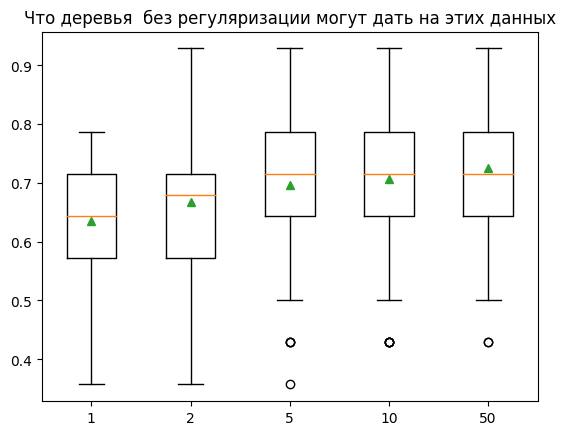

In [54]:
models = get_models(0, 0.3,0,1)
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, labels_pd_c,0)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.title('Что деревья  без регуляризации могут дать на этих данных')
pyplot.show()

Ну вот собственно что мы можем сделать с деревьями на таком маленьком датасете.
Еще есть интересные методы увеличения выборок вот такие, можно попробовать:

5. Balance the dataset with synthetic samples (SMOTE)

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

## СNNs
Теперь можно попробовать нейронную сеть на этих данных.. Поскольку их немного, нейронная сеть должна быть максимально простой.

Задаю сеть прямо здесь, и тренирую ее в этом блокноте,потому что мало данных, и мы можем себе позволить это сделать.
Я задаю сеть без конволюций, потому что в нашем эксперименте они не оправданы ( мы можем обсудить, сеть с конволюцией я тоже попробовала уже). Т.о, это простейшая нейронная сеть из двух слоев. 

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# define the model using pytorch https://github.com/harryjdavies/Python1D_CNNs/blob/master/CCN1D_pytorch_activity.py

n_features=24 # 1 dimension
n_classes = 1 # binary classification PD / Control
batch_size = 4

class Vanilla_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = n_features, out_features = 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer2 =  nn.Linear(128,256)
        self.layer3 =  nn.Linear(256,n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.sigm(out)
        return out


In [28]:
my_vanilla_net = Vanilla_Net()
print(my_vanilla_net)

Vanilla_Net(
  (layer1): Linear(in_features=24, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
  (sigm): Sigmoid()
)


In [31]:
# from torchviz import make_dot 
# make_dot(my_vanilla_net)

Я также написала даталоадер, чтобы подгружать наши данные. Вот он задан:

In [69]:
import torch
import numpy as np


def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical


class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = ID
        y = self.labels[index] #to_categorical(self.labels[index], 2)

        return X, y

Для этой сети, я сразу же сохранила данные. Я не использую коэффициенты, это просто данные из позы с выпрямленными руками и данные с позы Хуторской, просуммированные. Мы считали Х выше в этом блокноте.

In [70]:
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 150
total_step = len(X)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [71]:
# Generators
X = features_v_pd_c +  features_h_pd_c
print(X.shape, len(labels_pd_c))
training_set = Dataset(X, labels_pd_c)
training_generator = torch.utils.data.DataLoader(training_set, **params)

(28, 24) 28


In [81]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

Epoch 000: | Loss: 24.44808 | Acc: 72.000
Epoch 001: | Loss: 24.60026 | Acc: 75.000
Epoch 002: | Loss: 24.91174 | Acc: 71.000
Epoch 003: | Loss: 24.44773 | Acc: 78.000
Epoch 004: | Loss: 24.77293 | Acc: 71.000
Epoch 005: | Loss: 25.16822 | Acc: 69.000
Epoch 006: | Loss: 24.83289 | Acc: 74.000
Epoch 007: | Loss: 24.61547 | Acc: 71.000
Epoch 008: | Loss: 24.46149 | Acc: 72.000
Epoch 009: | Loss: 24.46379 | Acc: 72.000
Epoch 010: | Loss: 24.60359 | Acc: 71.000
Epoch 011: | Loss: 24.38470 | Acc: 72.500
Epoch 012: | Loss: 24.47989 | Acc: 72.000
Epoch 013: | Loss: 24.47660 | Acc: 72.000
Epoch 014: | Loss: 24.60307 | Acc: 75.000
Epoch 015: | Loss: 24.52088 | Acc: 72.000
Epoch 016: | Loss: 24.45830 | Acc: 76.000
Epoch 017: | Loss: 24.37859 | Acc: 76.000
Epoch 018: | Loss: 24.52243 | Acc: 79.000
Epoch 019: | Loss: 24.82949 | Acc: 69.500
Epoch 020: | Loss: 24.73180 | Acc: 71.000
Epoch 021: | Loss: 24.60013 | Acc: 71.000
Epoch 022: | Loss: 24.45150 | Acc: 72.000
Epoch 023: | Loss: 24.45988 | Acc:

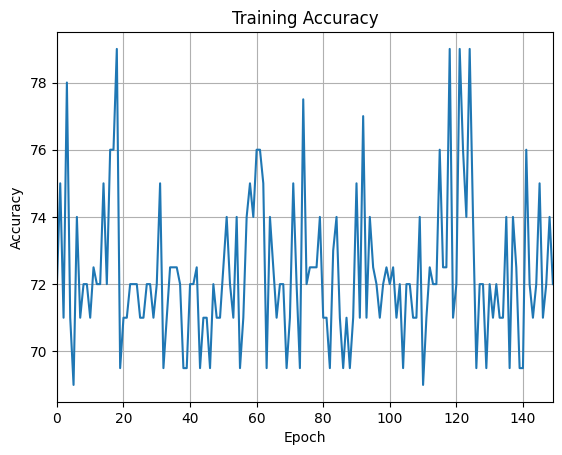

<Figure size 640x480 with 0 Axes>

In [107]:
# model
model = my_vanilla_net
model = model.float()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# training
# Loop over epochs
for epoch in range(max_epochs):
    epoch_loss = 0
    epoch_acc = 0

    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device) #torch.unsqueeze(local_batch,1)
#         print(local_batch.shape, local_labels.shape, local_labels)
        # Run the forward pass
        outputs = model(local_batch.float())
#       print(outputs,local_labels)
        outputs = outputs.squeeze()
        loss = criterion(outputs, local_labels.float())
        epoch_loss += loss.item()
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         # Track the accuracy
        total = local_batch.size(0)
        acc = binary_acc(outputs, local_labels)       
        epoch_acc += acc.item()
    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(training_generator):.5f} | Acc: {epoch_acc/len(training_generator):.3f}')
    acc_list_epoch.append(epoch_acc/len(training_generator))
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()
plt.savefig('train_accuracy.png')


In [ ]:
Попробуем сделать кросс-валидацию для нашей модели.

In [ ]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(X, y):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X[train], y[train], X[test], y[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores.append(acc)
 
# evaluate the model
acc = np.mean(cv_scores)
std = np.std(cv_scores)
print("Model accuracy: %.2f%% (+/- %.2f%%)" % (acc*100, std*100))